In [2]:
import pandas as pd
import numpy as np

#library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from math import sqrt
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = pd.read_excel("dataset.xlsx")

In [4]:
dataset

,tanggal,volume_produksi
0,2001-01-01,3.698909
1,2001-01-02,4.079162
2,2001-01-03,3.548420
3,2001-01-04,2.874586
4,2001-01-05,1.071931
...,...,...
8211,2023-06-26,2.012925
8212,2023-06-27,1.435956
8213,2023-06-28,0.349697
8214,2023-06-29,1.595183


In [5]:
# Remove rows where 'volume_produksi' is either 0 or NaN
data_bersih = dataset.copy()
data_bersih['volume_produksi'] = pd.to_numeric(data_bersih['volume_produksi'], errors='coerce')
data_bersih = data_bersih[data_bersih['volume_produksi'].notna() & (data_bersih['volume_produksi'] != 0)]

# Display the cleaned data
data_bersih.head()

,tanggal,volume_produksi
0,2001-01-01,3.698909
1,2001-01-02,4.079162
2,2001-01-03,3.548420
3,2001-01-04,2.874586
4,2001-01-05,1.071931


In [6]:
# Mengatur kolom 'tanggal' sebagai index
data_bersih['tanggal'] = pd.to_datetime(data_bersih['tanggal'])  # Pastikan kolom tanggal dalam format datetime
data_bersih.set_index('tanggal', inplace=True)

# Resample data harian ke bulanan dan hitung rata-rata bulanan
monthly_data = data_bersih.resample('M').mean()

monthly_data.head()

,volume_produksi
tanggal,
2001-01-31,2.137695
2001-02-28,1.914559
2001-03-31,2.155337
2001-04-30,1.881285
2001-05-31,2.132840


In [7]:
len(monthly_data)

270

In [8]:
monthly_data.head(37)

,volume_produksi
tanggal,
2001-01-31,2.137695
2001-02-28,1.914559
2001-03-31,2.155337
2001-04-30,1.881285
2001-05-31,2.132840
2001-06-30,1.915217
2001-07-31,2.109999
2001-08-31,2.204497
2001-09-30,1.959080


In [9]:
# Bulatkan kolom volume produksi menjadi angka desimal dengan dua angka di belakang koma
monthly_data['volume_produksi'] = monthly_data['volume_produksi'].round(2)

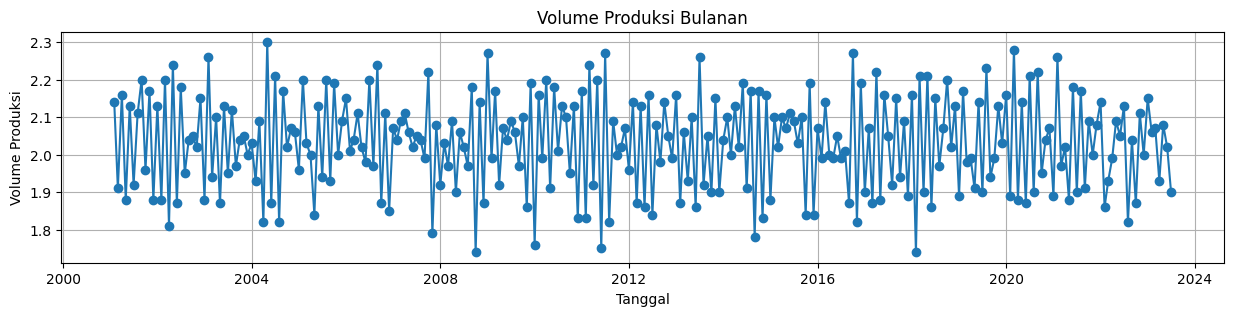

In [10]:
# Membuat plot dari data bulanan
plt.figure(figsize=(15,3))
plt.plot(monthly_data.index, monthly_data['volume_produksi'], marker='o')
plt.title('Volume Produksi Bulanan')
plt.xlabel('Tanggal')
plt.ylabel('Volume Produksi')
plt.grid(True)
plt.show()

In [11]:
# GRID SEARCH BLOCKED CROSS VALIDATION HOLT-WINTERS

# Define the parameter grid
alpha_values = np.arange(0, 1.1, 0.1)
beta_values = np.arange(0, 1.1, 0.1)
gamma_values = np.arange(0, 1.1, 0.1)

# Store results
best_model_per_iteration = []
overall_best_model = {"iteration": None, "train_range": None, "test_range": None, "alpha": None, "beta": None, "gamma": None, "mse": float("inf")}

# Perform blocked cross-validation
iteration = 1
for start in range(0, len(monthly_data) - 30 - 30 + 1, 30):
    train_end = start + 30
    test_end = train_end + 30
    train_data = monthly_data[start:train_end]
    test_data = monthly_data[train_end:test_end]

    best_mse = float("inf")
    best_params = None

    for alpha in alpha_values:
        for beta in beta_values:
            for gamma in gamma_values:
                try:
                    model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
                    predictions = model.forecast(len(test_data))
                    mse = mean_squared_error(test_data, predictions)

                    if mse < best_mse:
                        best_mse = mse
                        best_params = (alpha, beta, gamma)
                except:
                    # Skip invalid parameter combinations
                    continue

    if best_params:
        alpha, beta, gamma = best_params
        print(f"Iteration {iteration}: Train=(Month {start+1}-{train_end}), Test=(Month {train_end+1}-{test_end}), Alpha={alpha}, Beta={beta}, Gamma={gamma}, MSE={best_mse:.3f}")
        
        best_model_per_iteration.append((iteration, start+1, train_end, train_end+1, test_end, alpha, beta, gamma, best_mse))
        
        if best_mse < overall_best_model["mse"]:
            overall_best_model.update({
                "iteration": iteration,
                "train_range": (start+1, train_end),
                "test_range": (train_end+1, test_end),
                "alpha": alpha,
                "beta": beta,
                "gamma": gamma,
                "mse": best_mse
            })

    iteration += 1

print("\nBest Model:")
print(f"Iteration {overall_best_model['iteration']}: Train={overall_best_model['train_range']}, Test={overall_best_model['test_range']}, Alpha={overall_best_model['alpha']}, Beta={overall_best_model['beta']}, Gamma={overall_best_model['gamma']}, MSE={overall_best_model['mse']:.3f}")


Iteration 1: Train=(Month 1-30), Test=(Month 31-60), Alpha=0.0, Beta=0.0, Gamma=0.30000000000000004, MSE=0.017
Iteration 2: Train=(Month 31-60), Test=(Month 61-90), Alpha=0.0, Beta=0.0, Gamma=0.4, MSE=0.014
Iteration 3: Train=(Month 61-90), Test=(Month 91-120), Alpha=0.0, Beta=0.0, Gamma=0.0, MSE=0.020
Iteration 4: Train=(Month 91-120), Test=(Month 121-150), Alpha=0.0, Beta=0.0, Gamma=0.0, MSE=0.026
Iteration 5: Train=(Month 121-150), Test=(Month 151-180), Alpha=0.1, Beta=0.0, Gamma=0.4, MSE=0.020
Iteration 6: Train=(Month 151-180), Test=(Month 181-210), Alpha=0.0, Beta=0.0, Gamma=0.0, MSE=0.025
Iteration 7: Train=(Month 181-210), Test=(Month 211-240), Alpha=0.4, Beta=0.0, Gamma=0.30000000000000004, MSE=0.017
Iteration 8: Train=(Month 211-240), Test=(Month 241-270), Alpha=0.1, Beta=0.0, Gamma=0.2, MSE=0.015

Best Model:
Iteration 2: Train=(31, 60), Test=(61, 90), Alpha=0.0, Beta=0.0, Gamma=0.4, MSE=0.014


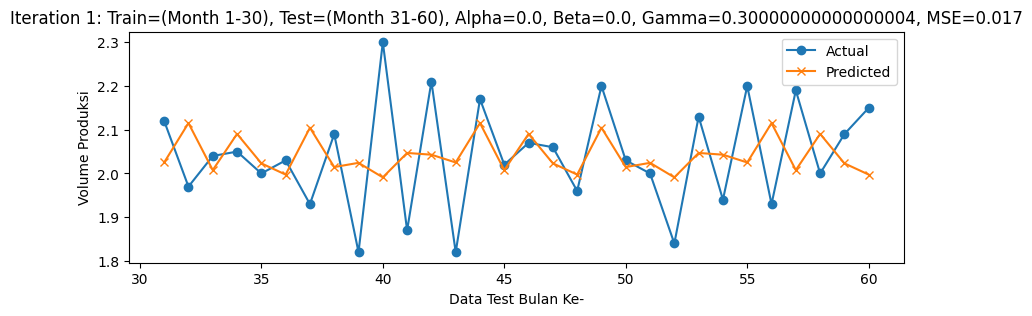

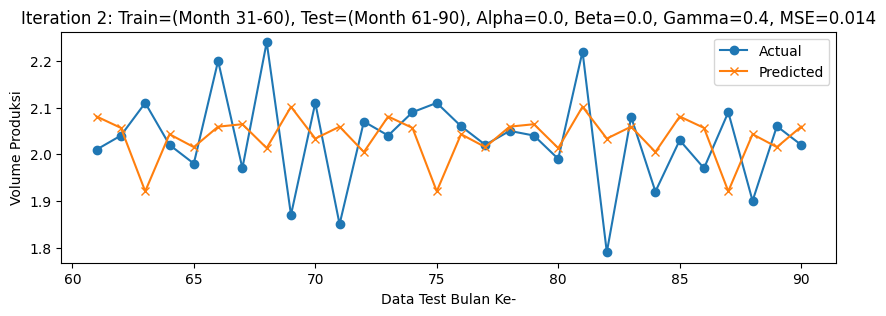

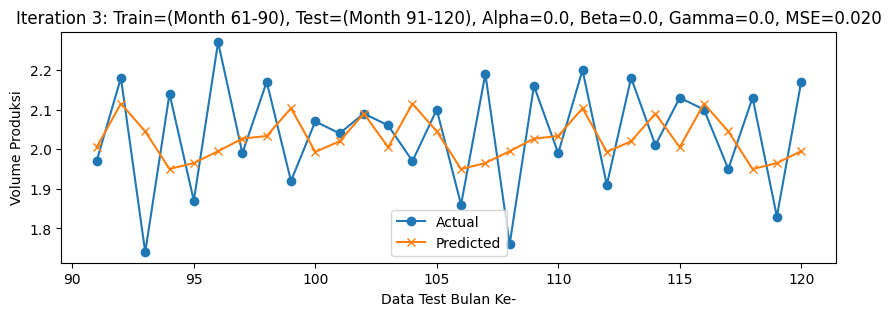

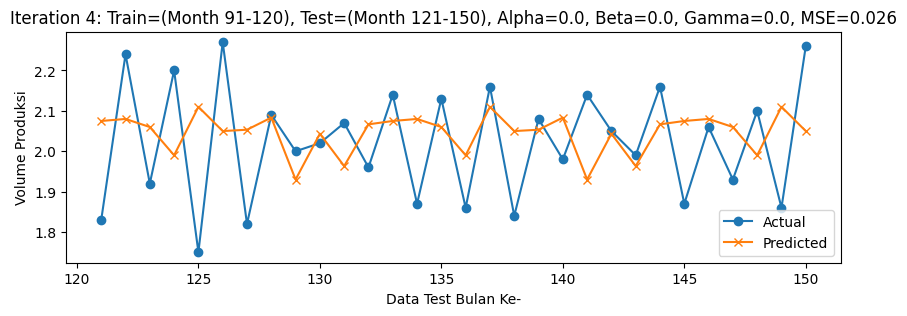

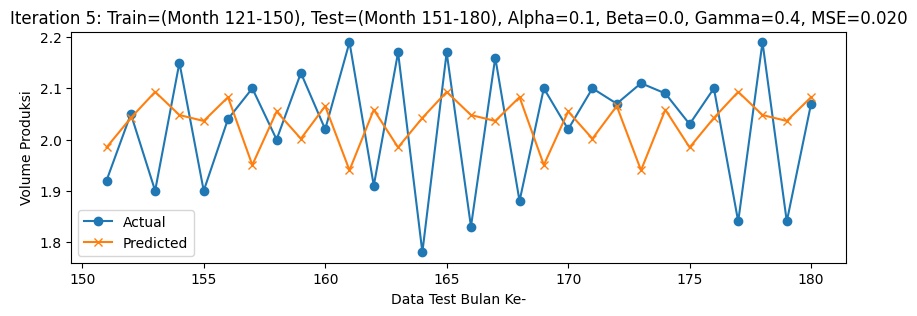

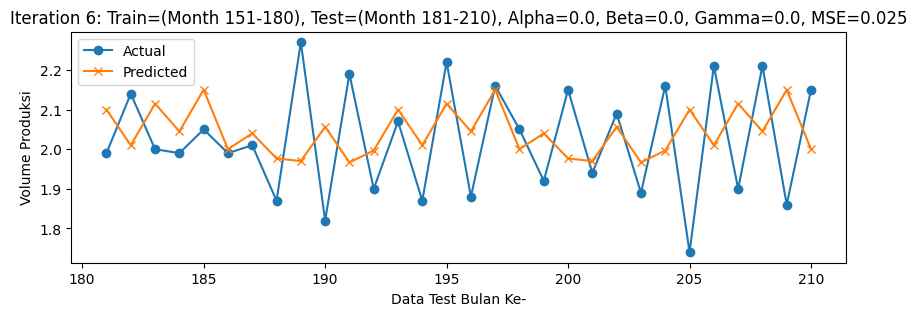

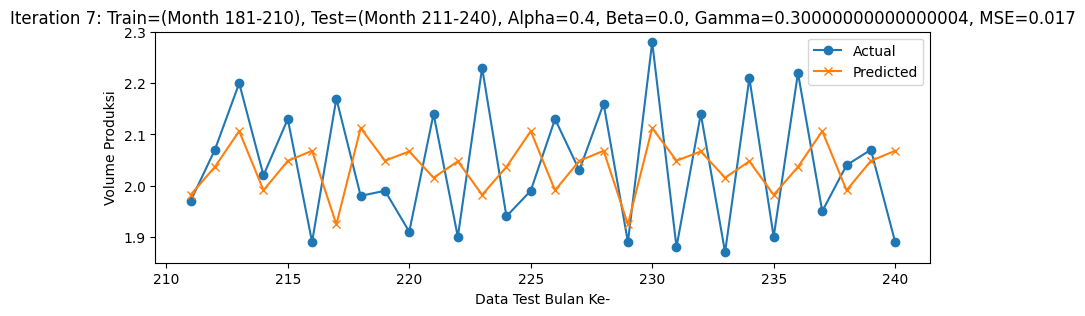

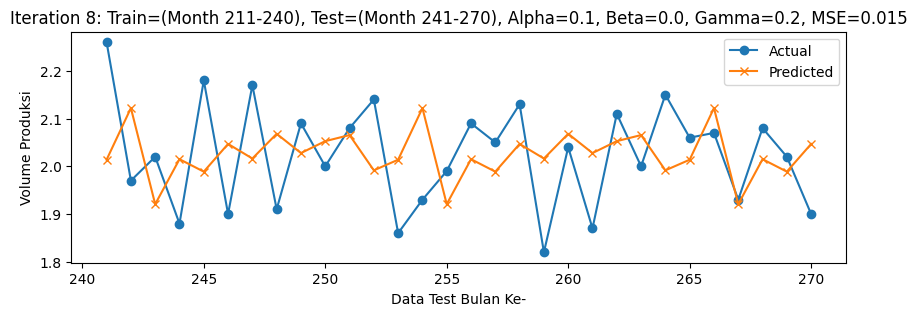

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Function to plot comparison for each iteration
def plot_comparison(iteration, train_range, test_range, alpha, beta, gamma, mse, train_data, test_data, predictions):
    plt.figure(figsize=(10, 3))
    plt.plot(range(test_range[0], test_range[1] + 1), test_data, label='Actual', marker='o')
    plt.plot(range(test_range[0], test_range[1] + 1), predictions, label='Predicted', marker='x')
    plt.title(f"Iteration {iteration}: Train=(Month {train_range[0]}-{train_range[1]}), Test=(Month {test_range[0]}-{test_range[1]}), Alpha={alpha}, Beta={beta}, Gamma={gamma}, MSE={mse:.3f}")
    plt.xlabel('Data Test Bulan Ke-')
    plt.ylabel('Volume Produksi')
    plt.legend()
    plt.grid(False)  # Disable grid
    plt.show()

# Plot comparisons for each iteration
for model_info in best_model_per_iteration:
    iteration, train_start, train_end, test_start, test_end, alpha, beta, gamma, mse = model_info
    train_data = monthly_data[train_start - 1:train_end]
    test_data = monthly_data[test_start - 1:test_end]
    
    # Re-fit model with the best parameters
    model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    predictions = model.forecast(len(test_data))
    
    # Plot comparison
    plot_comparison(iteration, (train_start, train_end), (test_start, test_end), alpha, beta, gamma, mse, train_data, test_data, predictions)


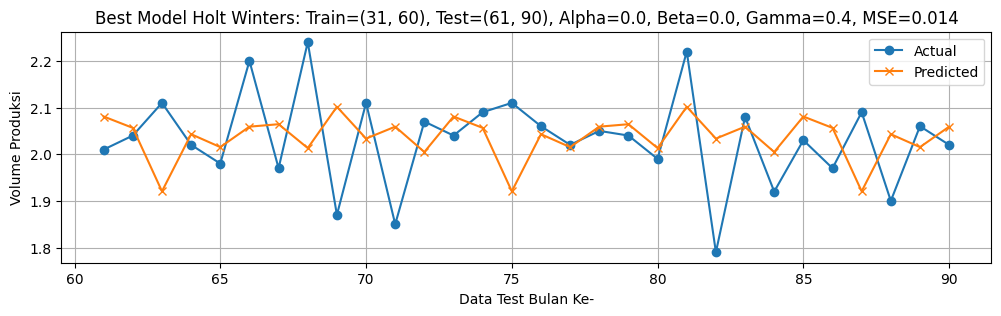

In [13]:
# Function to plot comparison for the best model
def plot_best_model(iteration, train_range, test_range, alpha, beta, gamma, mse, test_data, predictions):
    plt.figure(figsize=(12, 3))
    plt.plot(range(test_range[0], test_range[1] + 1), test_data, label='Actual', marker='o')
    plt.plot(range(test_range[0], test_range[1] + 1), predictions, label='Predicted', marker='x')
    plt.title(f"Best Model Holt Winters: Train=({train_range[0]}, {train_range[1]}), Test=({test_range[0]}, {test_range[1]}), Alpha={alpha}, Beta={beta}, Gamma={gamma}, MSE={mse:.3f}")
    plt.xlabel('Data Test Bulan Ke-')
    plt.ylabel('Volume Produksi')
    plt.legend()
    plt.grid(True)
    plt.show()

# Mengambil iterasi model terbaik berdasarkan MSE terendah
best_iteration = overall_best_model["iteration"] - 1  # Indeks dimulai dari 0
iteration_info = best_model_per_iteration[best_iteration]

# Ekstraksi informasi dari iterasi terbaik
iteration, train_start, train_end, test_start, test_end, alpha, beta, gamma, mse = iteration_info
train_data = monthly_data[train_start - 1:train_end]
test_data = monthly_data[test_start - 1:test_end]

# Re-fit model dengan parameter terbaik
best_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
predictions = best_model.forecast(len(test_data))

# Memanggil fungsi untuk memplot hasil model terbaik
plot_best_model(iteration, (train_start, train_end), (test_start, test_end), alpha, beta, gamma, mse, test_data['volume_produksi'], predictions)


In [14]:
# Mengambil data aktual untuk perbandingan
actual = test_data['volume_produksi']

# Menghitung Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, predictions)

# Menghitung Mean Squared Error (MSE)
mse = mean_squared_error(actual, predictions)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Menghitung Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual - predictions) / actual)) * 100

# Menampilkan hasil evaluasi
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")

MAE: 0.091
MSE: 0.014
RMSE: 0.118
MAPE: 4.515%
